In [1]:
!jupyter nbconvert --to html "C:/xampp/htdocs/ml_personalNGroup/Group/challenge3/notebooks/03-modeling.ipynb"

[NbConvertApp] Converting notebook C:/xampp/htdocs/ml_personalNGroup/Group/challenge3/notebooks/03-modeling.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 1 image(s).
[NbConvertApp] Writing 479839 bytes to C:\xampp\htdocs\ml_personalNGroup\Group\challenge3\notebooks\03-modeling.html


## Load dữ liệu đã được làm sạch

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

# 1. Load dữ liệu
train = pd.read_csv("../data/02_processed/train_clean.csv")

# Kiểm tra xem các cột cần loại bỏ có tồn tại không
cols_to_drop = ['Class', 'Id', 'Artist Name'] 
# 'Id' vô nghĩa, 'Artist Name' gây lỗi text, 'Class' là đáp án -> Phải drop hết
existing_drop = [c for c in cols_to_drop if c in train.columns]

X = train.drop(columns=existing_drop)
y = train['Class']

# 3. Chia tập dữ liệu
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Kiểm tra nhanh để yên tâm (Nếu in ra False là đúng)
print("Cột 'Class' còn trong X_train không?", 'Class' in X_train.columns)

Cột 'Class' còn trong X_train không? False


In [3]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((11516, 25), (2880, 25), (11516,), (2880,))

## Định nghĩa 6 mô hình gồm 3 mô hình tuyến tính và 3 mô hình phi tuyến tính và dùng kfold để chấm 

In [4]:
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.calibration import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

Dùng f1-macro để đánh giá vì: Mỗi lớp được đánh trọng số như nhau, không bị ảnh hưởng bởi mất cân bằng dữ liệu, phù hợp cho multi-class classification

In [5]:
# train đã được xử lý, không cần loại bỏ thêm cột nào nữa
X_train_num = X_train

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Danh sách các mô hình
# class_weight='balanced': Tự động phạt nặng nếu model đoán sai class nhỏ
models = [
    # --- Nhóm Tuyến tính ---
    ('LogReg', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)),
    ('Ridge', RidgeClassifier(class_weight='balanced', random_state=42)),
    ('LinSVC', LinearSVC(class_weight='balanced', random_state=42, dual=False)),
    
    # --- Nhóm Phi tuyến tính ---
    ('KNN', KNeighborsClassifier(n_neighbors=5)), # KNN không có class_weight nhưng bản chất nó phi tuyến
    ('RandForest', RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1)),
    ('XGBoost', xgb.XGBClassifier(eval_metric='mlogloss', random_state=42, n_jobs=-1)) 
]
results = []
names = []
for name, model in models:
    # scoring='f1_macro' để đánh giá đúng trên tập mất cân bằng
    scores = cross_val_score(model, X_train_num, y_train, cv=cv, scoring='f1_macro', n_jobs=-1)
    results.append(scores)
    names.append(name)
    print(f"{name}: {scores.mean():.4f} (+/- {scores.std():.4f})")

LogReg: 0.3784 (+/- 0.0123)
Ridge: 0.2589 (+/- 0.0074)
LinSVC: 0.3500 (+/- 0.0106)
KNN: 0.3825 (+/- 0.0089)
RandForest: 0.4265 (+/- 0.0088)
XGBoost: 0.4424 (+/- 0.0078)


Nhận xét: 

XGBoost điểm F1-Macro cao nhất mà độ lệch chuẩn (std) cũng thấp nhất (0.003) hứng tỏ mô hình rất ổn định

## Huấn luyện mô hình tốt nhất (XGBoost)

Sử dụng Optuna tìm siêu tham số tối ưu bằng kỹ thuật Bayesian optimization để tối ưu hóa hiệu suất


In [6]:
def objective(trial):
    # Optuna cho phép định nghĩa rất linh hoạt
    params = {
        'objective': 'multi:softmax',
        'eval_metric': 'mlogloss',
        'tree_method': 'hist', # Tăng tốc độ train
        'random_state': 42,
        'n_jobs': -1,
        'num_class': 11, # Dataset của bạn có 11 class (0-10)
        
        # Các siêu tham số cần tối ưu:
        'n_estimators': trial.suggest_int('n_estimators', 200, 1000), # Số lượng cây
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.2, log=True), # Log=True để ưu tiên số nhỏ
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0.0, 5.0), # Regularization
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True), # L1 Reg
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True), # L2 Reg
    }
    
    #Khởi tạo mô hình với params gợi ý
    model = xgb.XGBClassifier(**params)
    
    # Đánh giá bằng Cross Validation (F1-Macro)
    # Dùng StratifiedKFold để đảm bảo công bằng cho các Class nhỏ
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='f1_macro', n_jobs=-1)
    
    return scores.mean()

In [7]:
# import optuna

# optuna.logging.set_verbosity(optuna.logging.WARNING)
# print(" Bắt đầu tối ưu XGBoost với Optuna...")
# # Tạo một "Study" - hướng tới mục tiêu TỐI ĐA HÓA (maximize) điểm F1
# study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))
# # Tối ưu trong 30 trials
# study.optimize(objective, n_trials=30, show_progress_bar=True)

# print("\nĐã xong!")
# print(f"Best F1-Macro: {study.best_value:.4f}")
# print("Best Params:")
# print(study.best_params)

## Đánh giá hiệu suất của mô hình 

In [8]:
# Mô hình với stham số tối ưu nhất
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix

# Bộ tham số tối ưu từ Optuna của bạn
best_params = {
    'n_estimators': 947,
    'learning_rate': 0.032472472171970086,
    'max_depth': 5,
    'min_child_weight': 4,
    'subsample': 0.8080976090915397,
    'colsample_bytree': 0.7845194789596303,
    'gamma': 1.4647765642795072,
    'reg_alpha': 0.0019309717640234123,
    'reg_lambda': 1.3365684096943992e-08,
    # Cố định
    'objective': 'multi:softmax',
    'eval_metric': 'mlogloss',
    'tree_method': 'hist',
    'random_state': 42,
    'n_jobs': -1,
    'num_class': 11
}

# Khởi tạo mô hình
final_model = xgb.XGBClassifier(**best_params)

Đang chạy Cross-Validation Predict

=== CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

           0       0.37      0.24      0.29       500
           1       0.06      0.00      0.01      1098
           2       0.45      0.41      0.43      1018
           3       0.68      0.56      0.61       322
           4       0.46      0.28      0.35       310
           5       0.69      0.71      0.70      1157
           6       0.38      0.31      0.35      2069
           7       0.74      0.87      0.80       461
           8       0.61      0.55      0.58      1483
           9       0.51      0.54      0.52      2019
          10       0.46      0.66      0.54      3959

    accuracy                           0.50     14396
   macro avg       0.49      0.47      0.47     14396
weighted avg       0.47      0.50      0.48     14396



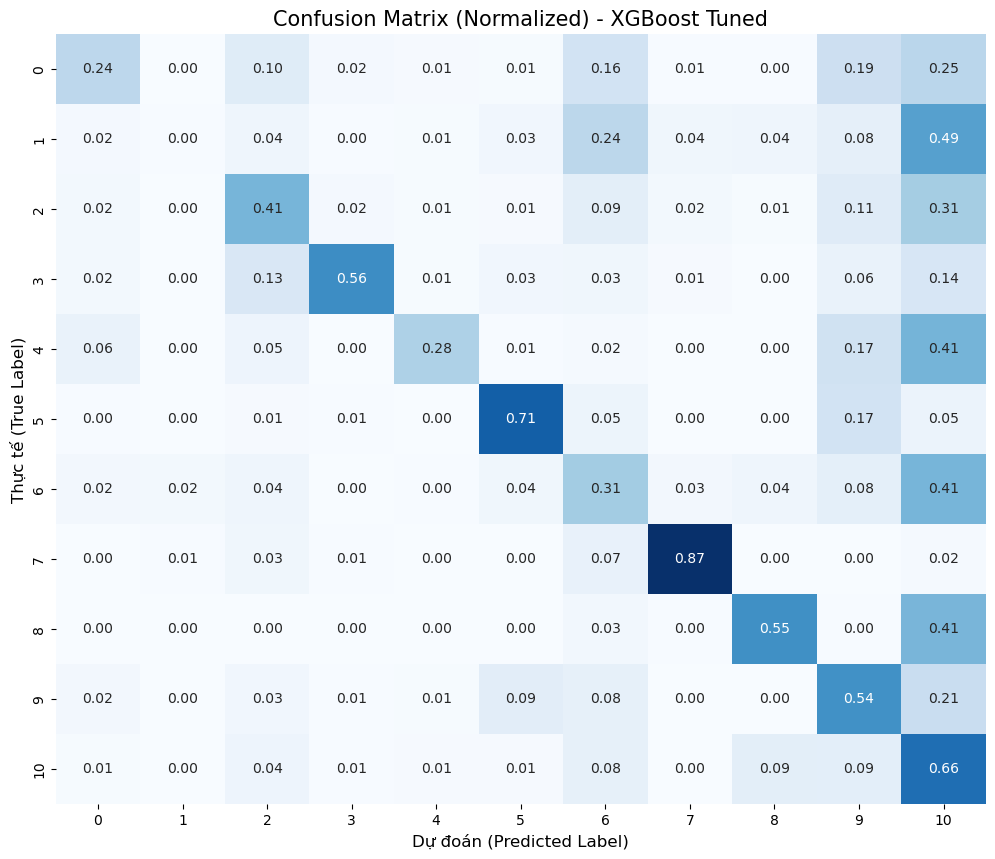

In [9]:
print("Đang chạy Cross-Validation Predict")
# Dự đoán chéo trên toàn bộ tập dữ liệu X, y
y_pred_cv = cross_val_predict(final_model, X, y, cv=5, n_jobs=-1)

# 1. Báo cáo chi tiết từng Class
print("\n=== CLASSIFICATION REPORT ===")
print(classification_report(y, y_pred_cv))

# 2. Vẽ Confusion Matrix chuẩn hóa
cm = confusion_matrix(y, y_pred_cv, normalize='true') # Normalize='true' để xem % đúng sai

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', cbar=False)
plt.title('Confusion Matrix (Normalized) - XGBoost Tuned', fontsize=15)
plt.xlabel('Dự đoán (Predicted Label)', fontsize=12)
plt.ylabel('Thực tế (True Label)', fontsize=12)
plt.show()

## Lưu model

In [10]:
import joblib
import os

model_dir = "../models"
os.makedirs(model_dir, exist_ok= True)
final_model.fit(X, y)
joblib.dump(final_model, os.path.join(model_dir, "xgboost_best_optuna.pkl"))


['../models\\xgboost_best_optuna.pkl']

Ghi chú:

Precision (Độ chính xác của dự báo): Precision cao nghĩa là mô hình "ít khi đoán bừa". Nếu nó đã nói là Class 7 thì rất đáng tin, vd Khi mô hình phán "Đây là nhạc cổ điển (Class 7)", thì có 74% khả năng nó nói đúng

Recall (Độ phủ / Độ nhạy):ví dụ có 100 bài nhạc cổ điển, mô hình đã vớt được 87 bài từ class7 

F1-Score (Điểm cân bằng): F1-Score phạt nặng nếu 1 trong 2 chỉ số trên quá thấp

Support (Số lượng mẫu thực tế)Số lượng bài hát thực tế của từng Class nằm trong tập dữ liệu

Nhận xét:

Điểm tốt class 7 F1 = 0.80, Recall = 0.87 có đặc trưng instrumentalness cao và energy thấp khác biệt hoàn toàn so với phần còn lại. Mô hình đã học rất tốt quy tắc này. Class 5 (F1 = 0.70):Nhờ vào việc bạn đã One-Hot Encoding cột Key, Class 1 (F1 = 0.01, Recall = 0.00)có đặc điểm giống hệt Class 10 hoặc Class 6. Mô hình không tìm thấy ranh giới nào để tách nó ra, nên nó quyết định "hy sinh" Class 1 để dồn phiếu cho các Class lớn hơn.Class 10 (F1 = 0.54, Recall = 0.66, Precision = 0.46): Recall cao nhưng Precision thấp nghĩa là: Mô hình rất hay đoán bừa vào Class 10 (theo kiểu "thà bắt nhầm còn hơn bỏ sót"). Vì Class 10 chiếm đa số, chiến thuật này giúp tăng Accuracy nhưng làm giảm độ chính xác của các Class khác.


In [11]:
# Lưu ý: X và y là biến bạn đã tạo ở đầu notebook (chưa split train/val)
final_model = xgb.XGBClassifier(**best_params)

print("Đang huấn luyện mô hình cuối cùng trên toàn bộ dữ liệu...")
final_model.fit(X, y)

# 3. Chuẩn bị dữ liệu Test
# Load lại test file sạch để đảm bảo đồng bộ
df_test_clean = pd.read_csv("../data/02_processed/test_clean.csv")
test_ids = df_test_clean['Id'] # Giữ lại ID để nộp bài

# Drop các cột không dùng (giống hệt lúc train)
cols_to_drop = ['Id', 'Artist Name'] 
X_test_submit = df_test_clean.drop(columns=[c for c in cols_to_drop if c in df_test_clean.columns])

# Reindex để đảm bảo thứ tự cột khớp 100% với X
X_test_submit = X_test_submit.reindex(columns=X.columns, fill_value=0)

# 4. Dự đoán
final_predictions = final_model.predict(X_test_submit)

# 5. Tạo file submission
submission = pd.DataFrame({
    'Id': test_ids,
    'Class': final_predictions
})

submission.to_csv('../data/submission.csv', index=False)
print("Đã lưu file: submission.csv")

Đang huấn luyện mô hình cuối cùng trên toàn bộ dữ liệu...
Đã lưu file: submission.csv


## Kết quả trên kaggle 
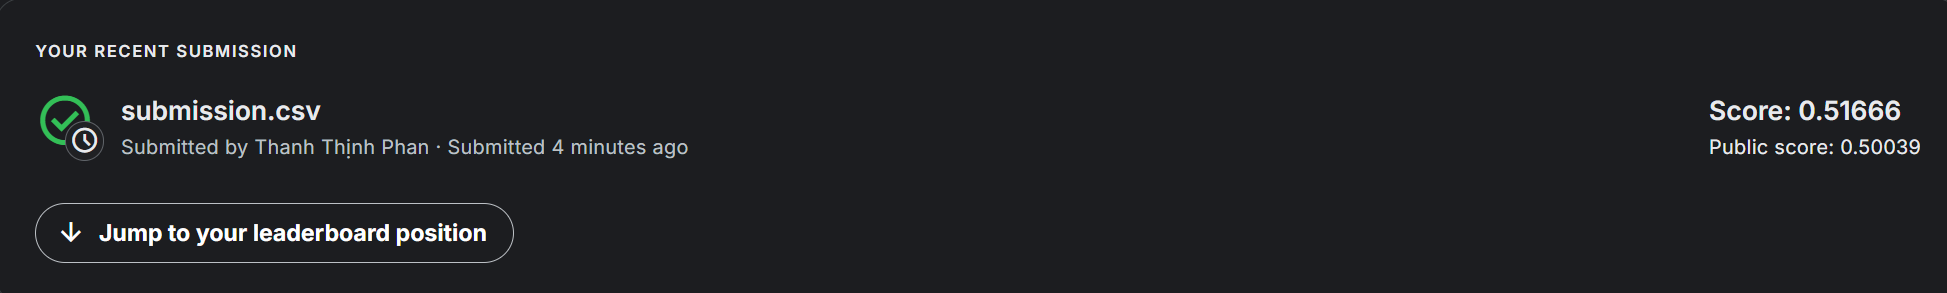